## Modules

In [1]:
import os
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
 
from datetime import datetime, timedelta
from itertools import product
from scipy.stats import norm

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

## Log-normal returns simulation

### Normal random vectors of log return & percentage return

In [2]:
miu0 = 0.12
sig0 = 0.24
k0 = 20
randVect0 = np.random.normal(miu0, sig0, k0)

print(f'Random log returns of {k0} periods:\n {randVect0}, \n')
print(f'Random percentage returns of {k0} periods:\n {np.exp(randVect0) - 1}')

Random log returns of 20 periods:
 [-0.72839076  0.40613094 -0.09925816  0.04688789  0.08742562 -0.37559948
  0.07236388 -0.10417563  0.20163301 -0.05501858  0.3237605   0.13654492
  0.62711611 -0.06928253  0.0880917  -0.08696346 -0.09141228  0.01478591
  0.29848494 -0.17072457], 

Random percentage returns of 20 periods:
 [-0.51731488  0.50099908 -0.09449109  0.04800451  0.09136109 -0.31312261
  0.07504647 -0.09893297  0.22339895 -0.05353244  0.3823162   0.14630637
  0.87220355 -0.06693698  0.09208826 -0.08328941 -0.08735863  0.01489576
  0.34781524 -0.15694626]


### Fixed-leverage-betting on normally distributed returns

In [3]:
def getSim_fixLev(initAmount=100, lev=1.00, miu=0.05, sig=0.2, numPeriod=60, numSim=1000):
    """
    Obtain dataframe of fixed-leverage-bet simulations, with returns of each interval normally distributed.
    Assume zero-cost-rebalance at the end of each period.
    initAmount: initial capital
    miu: (non-annualized) mean return
    sig: (non-annualized) sigma
    numPeriod: number of periods
    numSim: number of simulations
    """
    # Dict for recording different series of total equity
    dictAmount = {}
    # Generate a total of `numSim`= N series of normally distributed returns
    for num in range(numSim):
        # vector of log returns in each period and exponentiate
        arrPct = np.exp(np.random.normal(miu, sig, numPeriod))
        # convert into growth factor vector by converting to percentage change vector, multiply by leverage, and add 1
        arrFactor = 1 + lev * (arrPct - 1)
        # equity vector by cumulative multiplying by growth factors
        arrAmount = initAmount * arrFactor.cumprod()
        # IF equity drops to 0 or even below (due to over-leverage), stop betting, set the remaining equity to 1/10000
        # of initial amount and fix it in the remaining series (for the sake of legal semi-log equity curve plotting)
        # (This artificial "residual equity" is unreal assummption, the reality is more cruel than this!)
        numBet = 1
        amtRuin = initAmount / 10000
        while numBet <= numPeriod - 1:
            if arrAmount[numBet] <= amtRuin:
                for j in range(numBet, numPeriod):
                    arrAmount[j] = amtRuin
                break
            numBet += 1
        dictAmount[f's{num + 1}'] = arrAmount
        # Form dataframe from the `dictAmount` and transpose, so that each row corresponds to a betting series
    dfSim = pd.DataFrame(dictAmount).transpose()
    # Rename columns so that each number in column labels corresponds to the k-th trial
    dfSim = dfSim.rename(columns={k: (k + 1) for k in dfSim.columns})

    return dfSim

### Sample of 20 simulations of 12 periods

In [4]:
initAmount1 = 100
lev1 = 2.00
miu1 = 0.04
sig1 = 0.16
numPeriod1 = 12
numSim1 = 20

dfSim1 = getSim_fixLev(initAmount1, lev1, miu1, sig1, numPeriod1, numSim1) 
np.round(dfSim1, 2)

1       2       3       4       5       6       7       8       9   \
s1   187.98  183.62  199.03  179.76  196.97   77.55   87.45   89.91   91.91   
s2   122.66  169.98  213.40  325.26  336.04  320.50  390.99  474.84  439.50   
s3   118.63  127.51  149.13  191.55  195.36  155.84  126.60  205.81  149.65   
s4   108.34   77.64   81.61   90.08  127.34  173.86  282.99  262.75  237.57   
s5    98.81  162.63  165.22  150.56  208.44  262.15  159.38  265.95  235.86   
s6   104.24   83.20   96.30  135.34  269.63  318.44  334.76  313.19  189.46   
s7   146.07   88.39  107.76  110.53  140.75  126.86   74.22  103.75   60.82   
s8   145.52  266.95  303.62  313.38  495.22  656.67  733.11  578.04  457.51   
s9   112.37   98.50  170.72  213.92  294.50  329.10  237.72  406.95  557.14   
s10  133.75  193.77  264.63  325.73  194.05  267.06  380.24  576.86  750.24   
s11  151.16  177.04  219.10  206.84  290.32  335.85  285.08  348.74  588.84   
s12  168.77  149.98  242.47  145.32  190.38  200.55  285.41  427.12  698.22   
s13   91.14  119.62  114.81  194.79  227.49  367.13  318.85  285.44  356.92   
s14  180.54  277.08  167.07  238.12  136.28  194.08  240.09  236.61  216.67   
s15  114.41   84.43  107.85  141.22  212.45  206.02  142.41  189.16  204.08   
s16  137.60  190.47  190.14  168.05  253.33  270.17  308.83  264.62  280.97   
s17  111.19  106.14  107.21  128.89   76.00   62.41   78.29  110.75  165.11   
s18  109.20   51.93   80.71   94.13   86.95  121.16  100.29  118.66   82.13   
s19   83.40  102.84   93.07   98.33  140.81  120.77  111.44  117.11  127.41   
s20   67.74   50.01   45.83   48.82   53.24   65.90   83.79  100.03   74.84   

          10       11       12  
s1    123.16    80.39    78.42  
s2    627.37   694.41   736.41  
s3    141.64   178.74   189.26  
s4    253.45   387.70   577.84  
s5    411.02   221.69   222.98  
s6    227.16   235.16   282.33  
s7     69.19    95.26   157.15  
s8    449.22   563.37   775.21  
s9    664.83   680.72   923.72  
s10   575.14   424.75   465.72  
s11   706.51   852.00   704.18  
s12  1078.11  1291.89  2120.68  
s13   639.81   685.56   483.85  
s14   299.52   313.75   213.36  
s15   162.45   189.73   170.50  
s16   243.05   271.00   289.92  
s17   138.18   183.38   178.45  
s18   110.94    96.98    67.82  
s19   103.66    91.38    61.58  
s20   113.64   139.71   119.77

## Equity curve plotting

### Simulation KPIs

In [5]:
def getSimKPI_fixLev(initamt=100, lev=1.00, miu=0.05, sig=0.2, numPeriod=60, numsims=1000):
    """Obtain a dictionary of final performance KPI of simulations. """
    dfSim = getSim_fixLev(initamt, lev, miu, sig, numPeriod, numsims)
    dictKPI = {}
    dictKPI['miu'] = miu
    dictKPI['sig'] = sig
    dictKPI['lev'] = lev
    dictKPI['NAsharpe'] = round(miu * (numPeriod ** 0.5) / sig, 4)
    dictKPI['win%'] = round(100 * dfSim[dfSim[numPeriod] >= initamt].shape[0] / numsims, 2)
    dictKPI['amountAvg'] = round(dfSim[numPeriod].mean(), 2)
    dictKPI['amountMed'] = round(dfSim[numPeriod].median(), 2)
    dictKPI['amountStd'] = round(dfSim[numPeriod].std(), 2)

    return dfSim, dictKPI

### Sample 1 (same parameter as above)

In [6]:
initAmount1 = 100
lev1 = 1.5
miu1 = 0.03
sig1 = 0.15
numPeriod1 = 36
numSim1 = 1000

dfSim1, dictKPI1 = getSimKPI_fixLev(initAmount1, lev1, miu1, sig1, numPeriod1, numSim1) 
dictKPI1

{'miu': 0.03,
 'sig': 0.15,
 'lev': 1.5,
 'NAsharpe': 1.2,
 'win%': 84.2,
 'amountAvg': 1026.96,
 'amountMed': 410.72,
 'amountStd': 2347.29}

### Function

In [7]:
def plotSim_fixLev(initAmount=100, lev=1.00, miu=0.05, sig=0.2, numPeriod=60, numSim=1000):
    """Plot equity curves from the betting simulations."""
    # Dataframe and KPI dict from `getSimKPI()` function
    dfSim, dictKPI = getSimKPI_fixLev(initAmount, lev, miu, sig, numPeriod, numSim)
    # First line of diagram title
    title = f'{numSim} simulations of {numPeriod}-periods \n'
    title += f'leverage {round(lev, 4)}, miu {round(100*miu, 2)}%, sig {round(100*sig, 2)}%\n'
    # Percentage of final equity above or equal to initial amount
    winrate = dictKPI['win%']
    amountAvg = dictKPI['amountAvg'] # Arithmetic mean of final equity
    amountMed = dictKPI['amountMed'] # Median of final equity
    amountStd = dictKPI['amountStd'] # SD of final equity
    # Attach key stats to title text
    sharpe = dictKPI['NAsharpe']
    title += f'NA-sharpe: {sharpe}, final winrate: {winrate}% \n'
    title += f'Final equity mean: {amountAvg}, median: {amountMed}, SD: {amountStd}'
    # Plot figure
    fig = plt.figure(figsize=(12, 9))
    # Append title
    fig.suptitle(title, fontsize=12)
    # Transpose the equity dataframe to plot
    dfplot = dfSim.transpose()
    # Adopt semi-log scale for fixed-percent-betting & linear scale for fixed-amount-betting
    plt.semilogy(dfplot)
    plt.plot(dfplot.index, np.repeat(initAmount, numPeriod), color='black', linewidth=3, linestyle='dashed')
    plt.show()

### Plotting simulations of sample 1

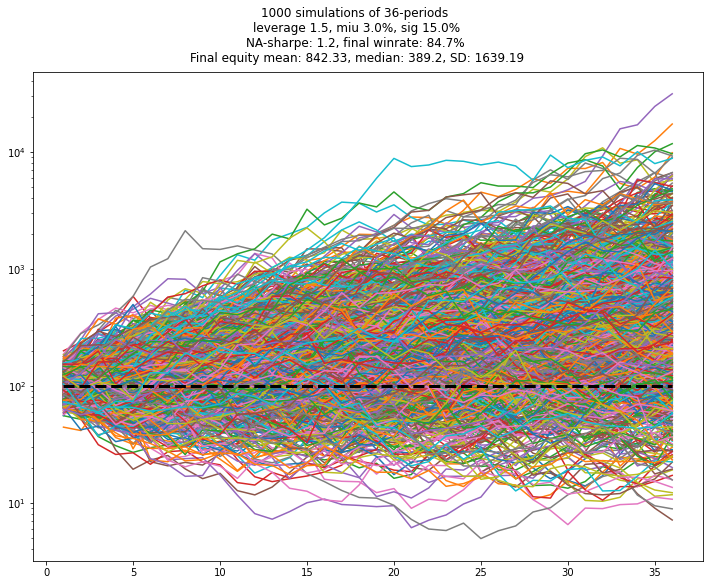

In [8]:
plotSim_fixLev(initAmount1, lev1, miu1, sig1, numPeriod1, numSim1)

### Reduce  `sig` with everything else unchanged

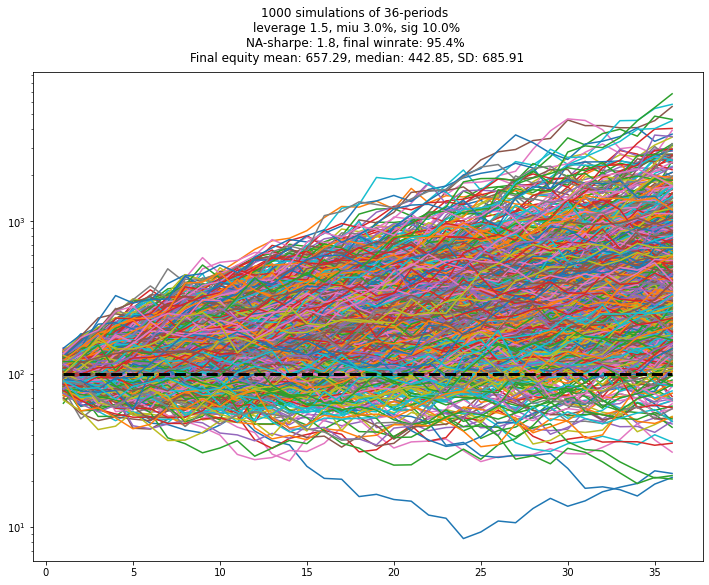

In [9]:
sig2 = 0.1
plotSim_fixLev(initAmount1, lev1, miu1, sig2, numPeriod1, numSim1)

### Raise both `miu` & `sig` but keeps NA-sharpe and leverage unchanged

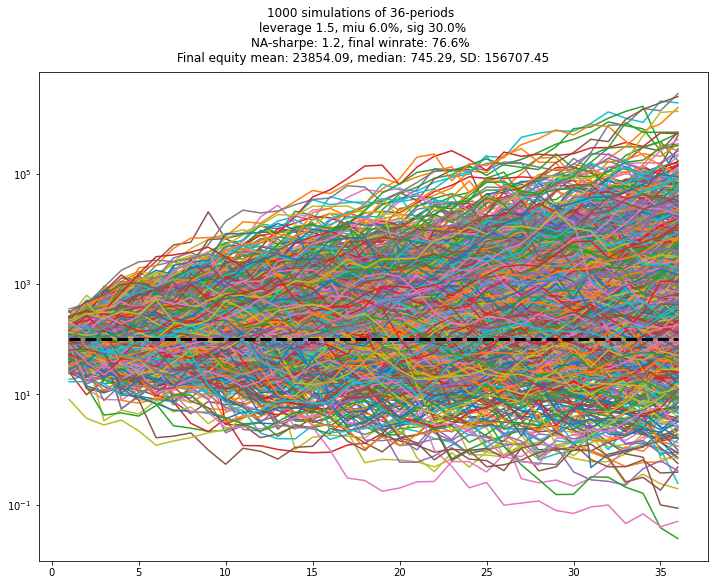

In [10]:
sharpe1 = 1.2 / (numPeriod1 ** 0.5)
miu3 = 0.06
sig3 = sig1 * miu3 / miu1

plotSim_fixLev(initAmount1, lev1, miu3, sig3, numPeriod1, numSim1)


### Function to check MDD

In [11]:
def getSimMDD(dfSim, levelsMDD=(0.2, 0.5, 0.8, 0.9)):
    """Obtain percentage of simulations with final amount dropping below the given equity threshold."""
    # Transpose the simulation dataframe
    dfSimT = dfSim.transpose()
    numTrial = dfSim.shape[1]
    numSim = dfSim.shape[0]
    # Compute MDD
    dfMDD = pd.DataFrame(columns=dfSimT.columns)
    for col in dfSimT.columns:
        dfMDD[col] = (dfSimT[col] / dfSimT[col].cummax() - 1).cummin()
    # Tranpose back to match original shape
    dfMDD = dfMDD.transpose()
    # Compute percentage of simulations having MDD greater than the levels
    dictMDD = {}
    for value in levelsMDD:
        dictMDD[value] = dfMDD[dfMDD[numTrial] <= -value].shape[0] / numSim

    return dfMDD, dictMDD   

### Using example 1

In [12]:
dfMDD1, dictMDD1 = getSimMDD(dfSim1)
print(f'Percentage of betting series suffering \n')

for key, value in dictMDD1.items():
    print(f'{round(100*key)}% MDD: {round(100*value, 2)}%')

Percentage of betting series suffering 

20% MDD: 99.7%
50% MDD: 70.0%
80% MDD: 9.0%
90% MDD: 2.0%


### Using example 3

In [13]:
dfSim3, dictKPI3 = getSimKPI_fixLev(initAmount1, lev1, miu3, sig3, numPeriod1, numSim1) 

dfMDD3, dictMDD3 = getSimMDD(dfSim3)
print(f'Percentage of betting series suffering \n')

for key, value in dictMDD3.items():
    print(f'{round(100*key)}% MDD: {round(100*value, 2)}%')

Percentage of betting series suffering 

20% MDD: 100.0%
50% MDD: 98.9%
80% MDD: 65.8%
90% MDD: 38.9%


## Optimal leverage (Kelly formula of continuous returns)

### Expected geometric growth (for normally distributed returns)

- Reference: Edward Thorp, The Kelly Criterion in Blackjack, Sports Betting, and the Stock Market (1997)

In [14]:
def getNormalGrowth(lev=1.00, miu=0.03, sig=0.15, n=1):
    """Obtain expected geometric returns of random walk returns."""
    logGrowth = lev * (miu - sig ** 2 * lev / 2)

    return np.exp(n * logGrowth)

def plotNormalGrowth(miu=0.03, sig=0.15, n=1, levMin=0.20, levMax=4.0, step=0.001):
    """Plot expected geometric growth given miu & sigma, and identify optimal leverage."""
    # Form pandas Series of expected return of varying leverage
    arrLev = np.arange(levMin, levMax, step)
    dictGrowth = {lev: getNormalGrowth(lev, miu, sig, n) for lev in arrLev}
    dfGrowth = pd.DataFrame(pd.Series(dictGrowth))
    # Plot interactive diagram of f-percent curve
    fig = px.line(x=dfGrowth.index, y=dfGrowth[0], labels={'x': 'lev', 'y': f'growth factor on {n} periods'})
    fig.add_trace(go.Scatter(x=dfGrowth.index, y=np.repeat(0, len(arrLev)), name='0%'))
    # Identify optimal leverage
    bestLev = round(dfGrowth[0].idxmax(), 4)
    bestGrowth = round(dfGrowth[0].max(), 4)
    fig.add_trace(go.Scatter(x=(bestLev, ), y=(bestGrowth, ), line_color='green', name='Opt-lev', mode='markers+text',
                             marker_size=10, text=f'{bestLev, round(bestGrowth, 4)}', textposition='bottom center'))
    # Title
    fig.update_layout(title=f'Expected geometric growoth of N({miu}, {sig})', title_x=0.5, width=1000, height=500)
    # Show diagram
    fig.show()

### Example 1

In [15]:
getNormalGrowth(lev1, miu1, sig1, numPeriod1)

2.031450357967213

In [16]:
plotNormalGrowth(miu1, sig1, numPeriod1)

### Example 2

In [17]:
plotNormalGrowth(miu1, sig2, numPeriod1, 1.0, 5.0)

### Example 3

In [18]:
plotNormalGrowth(miu3, sig3, numPeriod1, 0.2, 2.0)

### Kelly optimal leverage (for normally distributed returns ONLY)

In [19]:
def getkellyLev(miu, sig):
    """Obtain Kelly formula of optimal leverage."""
    return round(max(miu / sig**2, 0), 4)

### Kelly leverage for a bunch of (`miu`, `sig`) pairs

- reasonable range of monthly returns: 0.5% - 5%  (annualized log-returns: 6% - 60%)
- reasonable range of monthly volatility: 6% - 40%  (annualized volatility:  20% - 140%)

In [20]:
arrMiu = np.arange(0.5, 4.5, 0.5) / 100
arrSig = np.arange(0.2, 1.5, 0.12) / (12 ** 0.5)
numMonth = 36

dfLev = pd.DataFrame()
dfSharpe = pd.DataFrame()
dfAmount = pd.DataFrame()

for miu, sig in product(arrMiu, arrSig):
    optLev = round(miu / sig ** 2, 4)
    dfLev.loc[f'{round(100*miu, 2)}%', f'{round(100*sig, 2)}%'] = optLev
    dfSharpe.loc[f'{round(100*miu, 2)}%', f'{round(100*sig, 2)}%'] = round(miu / sig * (numMonth ** 0.5), 4)
    dfAmount.loc[f'{round(100*miu, 2)}%', f'{round(100*sig, 2)}%'] = round(100 * getNormalGrowth(optLev, miu, sig, numMonth), 2)

dfLev

5.77%   9.24%   12.7%  16.17%  19.63%  23.09%  26.56%  30.02%  33.49%  \
0.5%    1.5  0.5859  0.3099  0.1913  0.1298  0.0937  0.0709  0.0555  0.0446   
1.0%    3.0  1.1719  0.6198  0.3827  0.2595  0.1875  0.1418  0.1109  0.0892   
1.5%    4.5  1.7578  0.9298  0.5740  0.3893  0.2812  0.2127  0.1664  0.1338   
2.0%    6.0  2.3438  1.2397  0.7653  0.5190  0.3750  0.2836  0.2219  0.1784   
2.5%    7.5  2.9297  1.5496  0.9566  0.6488  0.4687  0.3544  0.2774  0.2229   
3.0%    9.0  3.5156  1.8595  1.1480  0.7785  0.5625  0.4253  0.3328  0.2675   
3.5%   10.5  4.1016  2.1694  1.3393  0.9083  0.6562  0.4962  0.3883  0.3121   
4.0%   12.0  4.6875  2.4793  1.5306  1.0381  0.7500  0.5671  0.4438  0.3567   

      36.95%  40.41%  
0.5%  0.0366  0.0306  
1.0%  0.0732  0.0612  
1.5%  0.1099  0.0918  
2.0%  0.1465  0.1224  
2.5%  0.1831  0.1531  
3.0%  0.2197  0.1837  
3.5%  0.2563  0.2143  
4.0%  0.2930  0.2449

### NA-sharpe for the above (`miu`, `sig`) pairs

In [21]:
dfSharpe

5.77%   9.24%   12.7%  16.17%  19.63%  23.09%  26.56%  30.02%  33.49%  \
0.5%  0.5196  0.3248  0.2362  0.1856  0.1528  0.1299  0.1130  0.0999  0.0896   
1.0%  1.0392  0.6495  0.4724  0.3712  0.3057  0.2598  0.2259  0.1999  0.1792   
1.5%  1.5588  0.9743  0.7086  0.5567  0.4585  0.3897  0.3389  0.2998  0.2688   
2.0%  2.0785  1.2990  0.9448  0.7423  0.6113  0.5196  0.4518  0.3997  0.3584   
2.5%  2.5981  1.6238  1.1809  0.9279  0.7641  0.6495  0.5648  0.4996  0.4479   
3.0%  3.1177  1.9486  1.4171  1.1135  0.9170  0.7794  0.6778  0.5996  0.5375   
3.5%  3.6373  2.2733  1.6533  1.2990  1.0698  0.9093  0.7907  0.6995  0.6271   
4.0%  4.1569  2.5981  1.8895  1.4846  1.2226  1.0392  0.9037  0.7994  0.7167   

      36.95%  40.41%  
0.5%  0.0812  0.0742  
1.0%  0.1624  0.1485  
1.5%  0.2436  0.2227  
2.0%  0.3248  0.2969  
2.5%  0.4059  0.3712  
3.0%  0.4871  0.4454  
3.5%  0.5683  0.5196  
4.0%  0.6495  0.5938

### Expected final equity on optimal leverage

In [22]:
dfAmount

5.77%    9.24%   12.7%  16.17%  19.63%  23.09%  26.56%  30.02%  \
0.5%     114.45   105.41  102.83  101.74  101.17  100.85  100.64  100.50   
1.0%     171.60   123.48  111.80  107.13  104.78  103.43  102.58  102.02   
1.5%     337.03   160.74  128.54  116.76  111.08  107.89  105.91  104.60   
2.0%     867.11   232.51  156.25  131.72  120.54  114.45  110.75  108.32   
2.5%    2922.43   373.73  200.84  153.80  133.90  123.48  117.29  113.29   
3.0%   12902.42   667.55  272.95  185.87  152.26  135.49  125.82  119.69   
3.5%   74620.47  1324.98  392.25  232.51  177.22  151.20  136.70  127.72   
4.0%  565332.98  2922.43  596.03  301.03  211.15  171.60  150.43  137.65   

      33.49%  36.95%  40.41%  
0.5%  100.40  100.33  100.28  
1.0%  101.62  101.33  101.11  
1.5%  103.68  103.01  102.51  
2.0%  106.63  105.41  104.51  
2.5%  110.55  108.59  107.13  
3.0%  115.54  112.60  110.43  
3.5%  121.73  117.53  114.45  
4.0%  129.28  123.48  119.28

## Adopt real stock price and check historical results on using leverage

### Collecting OHLC data

In [25]:
import yfinance as yf

def getYahooData(listSymbol, adjust=True, strStart='1990-01-01', strEnd='2046-12-31'):
    """Scrape via yahoo API to obtain data for a listSymbol."""
    strSymbol = ' '.join(listSymbol)
    dictRename = {'Date': 'date', 'Open': 'op', 'High': 'hi', 'Low': 'lo', 'Close': 'cl',
                  'Volume': 'vol', 'Adj Close': 'adj_cl', 'Dividends': 'div', 'Stock Splits': 'split'}
    fieldsOHLC = ['op', 'hi', 'lo', 'cl']
    columnsData = fieldsOHLC + ['vol', 'div']

    dictData = {}

    try:
        dfData = yf.download(strSymbol, start=strStart, end=strEnd, auto_adjust=False, actions=True,
                             group_by='Tickers', threads=16)
    except:
        dfData = pd.DataFrame()

    for symbol in listSymbol:
        try:
            dfSymbol = dfData[(symbol,)].dropna()  # Raw data for the symbol
            dfSymbol = dfSymbol[(dfSymbol['Volume'] > 0) | (dfSymbol['High'] > dfSymbol['Low'])]  # Filter bad data
            dfSymbol.reset_index(inplace=True)
            dfSymbol.rename(columns=dictRename, inplace=True)
            dfSymbol.set_index('date', inplace=True)

            if not adjust:
                dfSymbol = dfSymbol[columnsData]
                dfSymbol.rename(columns={field: f'{symbol}_{field}' for field in columnsData}, inplace=True)
            else:
                adjfactor = dfSymbol['adj_cl'] / dfSymbol['cl']
                for field in fieldsOHLC:
                    dfSymbol[f'adj_{field}'] = dfSymbol[field] * adjfactor
                dfSymbol['adj_vol'] = dfSymbol['vol'] / adjfactor
                dfSymbol = dfSymbol[[f'adj_{field}' for field in columnsData[:-1]]]
                dfSymbol.rename(columns={f'adj_{field}': f'{symbol}_{field}' for field in columnsData[:-1]}, inplace=True)
                dfSymbol = np.round(dfSymbol, 4)

            dictData[symbol] = dfSymbol
        except:
            print(f'Failed preparing data for {symbol}.')

    dfAll = pd.concat(dictData.values(), axis=1, join='inner')
    dfAll.fillna(method='ffill', inplace=True)

    return dfAll

In [24]:
listSymbol = ['SPY', 'QQQ', 'IWM', 'ARKK', 'EWH', 'AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'JPM']

strStart = '2010-07-02'
strEnd = '2022-07-01'
dfAll = getYahooData(listSymbol, True, strStart, strEnd)
dfAll.info()

[*********************100%***********************]  11 of 11 completed


D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning:

indexing past lexsort depth may impact performance.

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning:

indexing past lexsort depth may impact performance.

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning:

indexing past lexsort depth may impact performance.

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning:

indexing past lexsort depth may impact performance.

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning:

indexing past lexsort depth may impact performance.

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning:

indexing past lexsort depth may impact performance.

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning:

indexing past lexsort depth may impact performance.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1921 entries, 2014-10-31 to 2022-06-30
Data columns (total 55 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SPY_op    1921 non-null   float64
 1   SPY_hi    1921 non-null   float64
 2   SPY_lo    1921 non-null   float64
 3   SPY_cl    1921 non-null   float64
 4   SPY_vol   1921 non-null   float64
 5   QQQ_op    1921 non-null   float64
 6   QQQ_hi    1921 non-null   float64
 7   QQQ_lo    1921 non-null   float64
 8   QQQ_cl    1921 non-null   float64
 9   QQQ_vol   1921 non-null   float64
 10  IWM_op    1921 non-null   float64
 11  IWM_hi    1921 non-null   float64
 12  IWM_lo    1921 non-null   float64
 13  IWM_cl    1921 non-null   float64
 14  IWM_vol   1921 non-null   float64
 15  ARKK_op   1921 non-null   float64
 16  ARKK_hi   1921 non-null   float64
 17  ARKK_lo   1921 non-null   float64
 18  ARKK_cl   1921 non-null   float64
 19  ARKK_vol  1921 non-null   float64
 20  EWH_op    19

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning:

indexing past lexsort depth may impact performance.



### Resample into monthly OHLC

In [27]:
def resampleOHLC(dfData, listSymbol, freq='M'):
    """Resample the OHLC dataframe into desired timeframe."""
    dictRule = {}
    for asset in listSymbol:
        dictSymbol = {f'{asset}_op': 'first', f'{asset}_cl': 'last', 
                      f'{asset}_hi': 'max', f'{asset}_lo': 'min', f'{asset}_vol': 'sum'}
        dictRule.update(dictSymbol)
        
    dfData1 = dfData.resample(rule=freq, label='right').agg(dictRule)
    
    return dfData1

dfAll_month = resampleOHLC(dfAll, listSymbol)
dfAll_month.iloc[-12:, :10]

SPY_op    SPY_cl    SPY_hi    SPY_lo       SPY_vol    QQQ_op  \
date                                                                         
2021-07-31  419.2029  428.6256  431.8414  412.4585  1.454899e+09  350.6426   
2021-08-31  430.4144  441.3814  442.8574  426.2700  1.282919e+09  362.7344   
2021-09-30  442.3589  420.8106  443.8153  420.4576  1.782439e+09  377.3515   
2021-10-31  422.6149  450.3363  450.6403  418.0846  1.538527e+09  355.5225   
2021-11-30  451.3659  446.7179  464.3489  446.4629  1.361783e+09  383.2425   
2021-12-31  452.6799  467.3776  471.3531  440.2068  1.963061e+09  394.8620   
2022-01-31  468.6962  442.7275  472.3175  414.0429  2.525485e+09  396.1307   
2022-02-28  443.4852  429.6595  450.8064  404.0844  2.335256e+09  361.7639   
2022-03-31  428.0949  445.8105  456.1059  408.4929  2.416890e+09  343.2206   
2022-04-30  447.4590  406.6822  451.9206  405.9024  1.881036e+09  360.6011   
2022-05-31  406.7513  407.6002  424.1143  375.6283  2.450102e+09  310.9253   
2022-06-30  409.8113  373.9893  412.0520  359.0397  1.980798e+09  308.5797   

              QQQ_cl    QQQ_hi    QQQ_lo       QQQ_vol  
date                                                    
2021-07-31  361.0410  365.3192  348.6323  8.212352e+08  
2021-08-31  376.2721  377.0743  356.4756  6.901471e+08  
2021-09-30  354.8880  379.0747  354.0354  9.403921e+08  
2021-10-31  382.7964  382.9649  347.3136  8.863546e+08  
2021-11-30  390.4402  405.2025  381.1209  9.302277e+08  
2021-12-31  394.9395  401.6201  374.7086  1.243054e+09  
2022-01-31  360.3940  399.3370  331.7054  1.860816e+09  
2022-02-28  344.2629  367.3925  315.9317  1.534147e+09  
2022-03-31  360.3327  369.5661  315.1277  1.698503e+09  
2022-04-30  311.3428  367.0615  310.6967  1.511160e+09  
2022-05-31  306.4030  328.2791  278.5039  1.963115e+09  
2022-06-30  279.1090  312.6448  267.6405  1.366996e+09

### Compute optimal leverage of all symbols in every 36-month-period

In [ ]:
nummonths = 36
startstr1 = dfmonthall.index[-1-nummonths].strftime('%Y-%m-%d')
endstr1 = dfmonthall.index[-1].strftime('%Y-%m-%d')

dfopthist = pd.DataFrame(columns=['miu', 'sig', 'NAsharpe', 'optlev'])
dfpct = pd.DataFrame()

for asset in assetlist:
    dfmonth = dfmonthall.loc[startstr1:endstr1, [f'{asset}_cl']]
    dfpct[f'{asset}_pct'] = np.round(np.log(dfmonth[f'{asset}_cl'] / dfmonth[f'{asset}_cl'].shift(1)), 5)
    dfpct[f'{asset}_chg'] = np.round(dfmonth[f'{asset}_cl'] / dfmonth[f'{asset}_cl'].shift(1) - 1, 5)
    dfopthist.loc[asset, 'miu'] = round(dfpct[f'{asset}_pct'].mean(), 5)
    dfopthist.loc[asset, 'sig'] = round(dfpct[f'{asset}_pct'].std(), 5)
    dfopthist.loc[asset, 'NAsharpe'] = round(dfopthist.loc[asset, 'miu']/dfopthist.loc[asset, 'sig']*(nummonths**0.5), 4)
    dfopthist.loc[asset, 'optlev'] = getkellylev(dfopthist.loc[asset, 'miu'] , dfopthist.loc[asset, 'sig'])
    
dfopthist

### 1x leverage cumulative returns

In [ ]:
dfnav0 = pd.DataFrame(index=dfpct.index)

for asset in assetlist:
    dfnav0[f'{asset}_NAV'] = (1 + dfpct[f'{asset}_chg']).cumprod()
    
dfnav0.iloc[0] = 1.00

for asset in assetlist:
    dfnav0[f'{asset}_DD'] = dfnav0[f'{asset}_NAV'] / dfnav0[f'{asset}_NAV'].cummax() - 1
    dfnav0[f'{asset}_MDD'] = dfnav0[f'{asset}_DD'].cummin()
    
productfield = product(assetlist, ['NAV', 'DD', 'MDD'])
dfnav0 = dfnav0[[f'{asset}_{field}' for asset, field in productfield]]
    
dfnav0.iloc[-6:, :12]

### Append 1x return statistics to optlev dataframe

In [ ]:
for asset in assetlist:
    dfopthist.loc[asset, '1xNAV'] = dfnav0.loc[endstr1, f'{asset}_NAV']
    dfopthist.loc[asset, '1xMDD'] = dfnav0.loc[endstr1, f'{asset}_MDD']   

dfopthist

### Adopt optimal leverage to past 36 months

In [ ]:
tryassetlist = [asset for asset in assetlist if dfopthist.loc[asset, 'optlev'] > 0]
dfnav = pd.DataFrame(index=dfpct.index)

for asset in tryassetlist:
    dfnav[f'{asset}_NAV'] = (1 + dfopthist.loc[asset, 'optlev'] * dfpct[f'{asset}_chg']).cumprod()
    
dfnav.iloc[0] = 1.0

for i in range(dfnav.shape[1]):
    for j in range(dfnav.shape[0]):
        if dfnav.iloc[j, i] <= 0:
            dfnav.iloc[j:, i] = dfnav.iloc[j, i]
            
for asset in tryassetlist:
    dfnav[f'{asset}_DD'] = dfnav[f'{asset}_NAV'] / dfnav[f'{asset}_NAV'].cummax() - 1
    dfnav[f'{asset}_MDD'] = dfnav[f'{asset}_DD'].cummin()

tryproductfield = product(tryassetlist, ['NAV', 'DD', 'MDD'])
dfnav = dfnav[[f'{asset}_{field}' for asset, field in tryproductfield]]

for asset in assetlist:
    if asset in tryassetlist:
        dfopthist.loc[asset, 'optNAV'] = dfnav.loc[endstr1, f'{asset}_NAV']
        dfopthist.loc[asset, 'optMDD'] = dfnav.loc[endstr1, f'{asset}_MDD']   
    else:
        dfopthist.loc[asset, 'optNAV'] = 1.000
        dfopthist.loc[asset, 'optMDD'] = 0.000

dfopthist

### Closer inspection on day-to-day basis using opt-lev to invest

In [ ]:
dfpctday = pd.DataFrame()

for asset in assetlist:
    dfday = dfohlcall.loc[startstr1:endstr1, [f'{asset}_cl']]
    dfpctday[f'{asset}_pct'] = np.round(np.log(dfday[f'{asset}_cl'] / dfday[f'{asset}_cl'].shift(1)), 5)
    dfpctday[f'{asset}_chg'] = np.round(dfday[f'{asset}_cl'] / dfday[f'{asset}_cl'].shift(1) - 1, 5)
    
dfnav1 = pd.DataFrame(index=dfpctday.index)

for asset in assetlist:
    dfnav1[f'{asset}_NAV'] = (1 + dfopthist.loc[asset, 'optlev'] * dfpctday[f'{asset}_chg']).cumprod()
    
dfnav1.iloc[0] = 1.0

for i in range(dfnav1.shape[1]):
    for j in range(dfnav1.shape[0]):
        if dfnav1.iloc[j, i] <= 0:
            dfnav1.iloc[j:, i] = dfnav1.iloc[j, i]
            
for asset in assetlist:
    dfnav1[f'{asset}_DD'] = dfnav1[f'{asset}_NAV'] / dfnav1[f'{asset}_NAV'].cummax() - 1
    dfnav1[f'{asset}_MDD'] = dfnav1[f'{asset}_DD'].cummin()

productfield = product(assetlist, ['NAV', 'DD', 'MDD'])
dfnav1 = dfnav1[[f'{asset}_{field}' for asset, field in productfield]]
    
dfoptday = dfopthist[['miu', 'sig', 'NAsharpe', 'optlev']]
dfoptday.rename(columns={'miu': 'month_miu', 'sig': 'month_sig'}, inplace=True)

for asset in assetlist:
    dfoptday.loc[asset, 'optNAV'] = dfnav1[f'{asset}_NAV'][-1]
    dfoptday.loc[asset, 'optMDD'] = dfnav1[f'{asset}_MDD'][-1]

dfoptday

### Search opt-lev from historical returns instead of Kelly formula

In [ ]:
dfoptreal = dfopthist[['miu', 'sig', 'NAsharpe', 'optlev']]
dfoptreal.rename(columns={'miu': 'month_miu', 'sig': 'month_sig'}, inplace=True)

dfoptreal['optNAV'] = 1.000
dfoptreal['optMDD'] = 0.000

levarr = np.arange(0.2, 5.1, 0.1)

for lev in levarr:
    dfnav2 = pd.DataFrame(index=dfpctday.index)
    
    for asset in assetlist:
        dfnav2[f'{asset}_NAV'] = (1 + lev * dfpctday[f'{asset}_chg']).cumprod()
        
    dfnav2.iloc[0] = 1.0

    for i in range(dfnav2.shape[1]):
        for j in range(dfnav2.shape[0]):
            if dfnav2.iloc[j, i] <= 0:
                dfnav2.iloc[j:, i] = dfnav2.iloc[j, i]
                
    for asset in assetlist:
        dfnav2[f'{asset}_DD'] = dfnav2[f'{asset}_NAV'] / dfnav2[f'{asset}_NAV'].cummax() - 1
        dfnav2[f'{asset}_MDD'] = dfnav2[f'{asset}_DD'].cummin()
        
        if dfnav2[f'{asset}_NAV'][-1] > dfoptreal.loc[asset, 'optNAV']:
            dfoptreal.loc[asset, 'optNAV'] = dfnav2[f'{asset}_NAV'][-1]
            dfoptreal.loc[asset, 'optMDD'] = dfnav2[f'{asset}_MDD'][-1]
            dfoptreal.loc[asset, 'optlev'] = lev
            
    print(f'{round(lev, 1)}x buy-hold-rebalance done.')

In [ ]:
dfoptreal